# Setup

Lattice: MxM matrix with entries $N_i$
Update rule for $N_i$: $N_i^{(t+1)} = N_i^{t} + r N_i^{t}(1 - \frac{N_i^{t}}{P_i}) \Delta t$
Parameters: $r, \Delta t$

$P_i$ is the productivity and depends on the "match" between Environment $E_i$ and Population skills $G_i$. Both are binary vectors.
We have $P_i = P_0 < E_i, G_i >$.

If population is too large it gets split: $p_s = \alpha (N_i - N_0)$ with $N_0 = 100$ and $\alpha = 1 / 400$

For the basic variant, we observe a sigmoid (solution of the logistic equation). The "squishing" depends on the productivity, and the initial population level as expected.

Do we really want a binary vector? Spatial correlation might be difficult to achieve, and is perhaps unrealistic. Probably not. Just normalize the thing in the end.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import noise
# import logging

In [2]:
# Helper funcs
def remove_all_indices(arr, target_index):
    """Remove indices that match target_index from array. OUTDATED"""
    mask = np.any(arr != target_index, axis=1)
    return arr[mask]

def remove_entry_from_list(from_list, target):
    """Removes ALL entries that are equal to target from a custom (nested) list"""
    if not isinstance(target, tuple):
        raise TypeError("Tuple needed")
    return [idx for idx in from_list if idx != target]

def flip_entries(array, p_flip=0.01):
    """ Flip values of a binary array with probability p_flip."""
    random_numbers = np.random.random(size=array.shape) # Generate floats in interval [0, 1)
    flip = random_numbers < p_flip
    return np.logical_xor(array, flip).astype(int) # Convert boolean to integer

def flip_single_entry_per_cell(array, rng, p_flip=0.01):
    """Flip one randomly selected entry (uniform pdf with rng) with probability p_flip.
    Env has shape (N, N, 10) - we need NxN random floats in [0, 1].
    E.g. for a NxN lattice, we have one expected flip per function call if p_flip = 1 / (NxN)
    """
    # TODO: Maybe add to class (num_entries doubly defined etc.)
    # I.e. empty skill vector undergoes mutation as well. FIX.
    height, width, num_entries = array.shape
    if height != width:
        raise ValueError(f"Only implemented for square lattices. Array has shape {array.shape}")
    nums = rng.uniform(low=0, high=1, size=(height, width))
    mask = nums < p_flip # select cells for which a flip happens

    # select number between 0 and num_env_vars for each cell
    flip_indices = rng.choice(range(num_entries), size=(height, width))

    # array[:, :, flip_indices] will not work as e.g. array[:, :, 0] will return a NxN array, so this will be NxNxNum_entries
    # instead, use numpy broadcasting magic (see indexing docs)
    # flip values where mask is True - alternative is np.ix_() for easy broadcasting
    rows, columns = np.arange(height), np.arange(width)
    replacement_vals = np.logical_xor(array[rows[:, np.newaxis], columns, flip_indices], mask).astype(int)

    # replace the values
    array[rows[:, np.newaxis], columns, flip_indices] = replacement_vals

    return array

def calculate_productivity(skill_arr, env_arr, prod_scaling=1, clip_min=None):
    """If skill_arr and env_arr are N-D with N > 1, calculate dot product along the last axis.
    Else, return dot product directly.
    The return value is multiplied with prod_scaling and clipped to clip_min if not None
    """
    assert np.all(skill_arr.shape == env_arr.shape), "Arrays don't have equal shapes"
    if len(skill_arr.shape) == 1: # 1D array
        arr = np.dot(skill_arr, env_arr)

    elif len(skill_arr.shape) == 2: # 2D array
        arr = np.einsum("ij, ij -> i", skill_arr, env_arr)

    elif len(skill_arr.shape) == 3: # 3D array
        arr = np.einsum("ijk, ijk -> ij", skill_arr, env_arr)

    else:
        raise TypeError("Only implemented for 1-3D arrays")

    arr *= (prod_scaling / skill_arr.shape[-1]) # scale and normalize
    if clip_min is not None:
        arr = np.clip(arr, clip_min, None) # clip to minimal value

    return arr

def set_neighborhood(distance=1, neigh_type="moore"):
    """
    General: Return possible neighbor candidates for a cell at location "cell_location".
    Variables to consider are radius (for a network), or type of neighborhood + distance of neighborhood (for lattice)
    For now we only consider a lattice.

    The current idea is to avoid a for loop here, i.e. we want to find a list of indices that we can slice the array with.
    The problem is that the indices possibly overlap, and we can't slice the array twice. Other, we have a solution using np.newaxis and numpy broadcasting magic.
    So it probably *is* better to use a for loop for now.

    Specific: Return the indices for a von-Neumann (taxicab metric) or Moore (incl. diagonals) neighborhood.
    The output of this function (x and y indices) are to be added to the desired point. Only used once and then stored.
    This returns a transposed index array which might not be ideal. Fix.
    """
    idx_range = np.arange(-distance, distance + 1) # assumes centered point
    r_indices, c_indices = np.meshgrid(idx_range, idx_range, indexing="ij") # use ij convention

    r_indices = r_indices.ravel() # flatten
    c_indices = c_indices.ravel()

    ele_center = distance * (2 * distance + 2) # an array of length N has its center at (N-1) // 2 -> 2D center at (N-1) / 2 x (N + 1)
    r_indices = np.delete(r_indices, ele_center) # delete center element
    c_indices = np.delete(c_indices, ele_center)

    if neigh_type == "moore":
        return r_indices, c_indices

    elif neigh_type == "von_neumann":
        to_keep = []
        for idx, (rr, cc) in enumerate(zip(r_indices, c_indices)):
            if (np.abs(rr) + np.abs(cc)) <= distance:
                to_keep.append(idx)

        return r_indices[to_keep], c_indices[to_keep]

    else:
        raise TypeError("Valid methods names are moore and von_neumann.")

def take_neighbors():
    """Returns an array of shape (num_points, distance, distance). First calculates the indices and then returns the values.
    For now, not implemented. Here we want to avoid a for loop"""
    pass

In [3]:
class Lattice:
    """Base object for population dynamics in medieval Europe. Square lattice.
    Central object is a square lattice with shape (time, x, x) which keeps the track of the population in each village.
    """

    def __init__(self, size=10, steps_sim=5_000, seed=50, idx_start=(0, 0), num_env_vars=10,
                 pop_min=100, pop_max=500, rate_growth=1/30, prod_min=1, rate_prod=200):
        """ Initializes lattice object with shape (time=steps_sim, size, size). assumes that env. vector
        and skill vector have the same length. Also initializes environment and skill vectors to calculate productivity.
        Current data type of population array is float (integer messes up the update rule)
        """
        self.rng = np.random.default_rng(seed=seed) # initialize RNG
        self.r0, self.c0 = idx_start # location of first settlement
        self.size = size # 1d size of square lattice
        self.shape = (steps_sim, size, size) # only square lattice - time is 0 axis
        self.population = np.zeros(self.shape) # villagers req. int type
        self.population[0, self.r0, self.c0] = 10

        self.num_env_vars = num_env_vars
        self.num_skill_vars = num_env_vars # assume same length for environment and skill vectors
        self.pop_min, self.pop_max = pop_min, pop_max # min / max population for a village to split (i.e. split with p=1 above max)

        self.rate_growth = rate_growth # set growth of population rate
        self.env = self.init_env_perlin(scale=0.2) # perlin env with scale 0.2 for now
        self.rate_prod = rate_prod # If this is large, small changes in the productivity are amplified
        self.prod_min = prod_min # minimum productivity to avoid division by zero in ODE

        # initialize skills - assign random bin. vector with length (num_skill_vars) to starting village
        self.skills = np.zeros((size, size, self.num_skill_vars))
        self.skills[self.r0, self.c0] = self.rng.integers(size=self.num_skill_vars, low=0, high=1, endpoint=True)
        self.prod = np.zeros((size, size))
        self.prod = calculate_productivity(self.skills, self.env, prod_scaling=self.rate_prod, clip_min=self.prod_min)

        # self.update_productivity() # init. productivity based on initial skill and env.

        self.num_iter = 1
        self.has_empty_neighbors = np.ones((size, size)) # whether a village has empty neighbors
        self.has_empty_neighbors = self.has_empty_neighbors > 0 # in the beginning all cells have empty neighbors

        self.is_empty = np.zeros((size, size)) # whether a village is empty
        self.is_empty[self.r0, self.c0] = 1 # all villages except starting loc are empty
        self.is_empty = self.is_empty == 0 # or .astype(bool)

        self.floats = self.rng.uniform(low=0.0, high=1.0, size=(M, M)) # draw floats from uniform distribution [0, 1)

        self.indices_r, self.indices_c = [], [] # indices to select neighbors
        self.prod_threshold = prod_min # If productivity is below this threshold, villagers stay idle. Init. equal to min. productivity.
        self.select_random_cell = False # If True, select cells probabilistically based on productivity

        self.env_mutation_rate = None # Probability that one entry of the environment vector per site flips
        self.skill_mutation_rate = None # Same but for skills
        self.skill_mutates_randomly = True # If skills mutate randomly or a more elaborate scheme is used (e.g. metropolis)

    def init_env_perlin(self, scale=0.1):
        """Create an environment of shape (size, size, num_entries) with Perlin noise.
        This yields spatially correlated noise. scale gives the correlation length"""
        # Populate environment with spatially correlated variables
        env_perlin = np.zeros((self.size, self.size, self.num_env_vars))
        for ii in range(M):
            for jj in range(M):
                env_perlin[ii, jj] = [noise.pnoise3(ii * scale, jj * scale, k * scale) for k in range(self.num_env_vars)]

        # Binarize the array
        for ii in range(self.num_env_vars):
            env_perlin[:, :, ii] = np.where(env_perlin[:, :, ii] > 0, 1, 0)

        return env_perlin

    def get_split_probs(self, population):
        """ Calculate the probability that each village splits. Uses uniform cdf."""
        factor = 1 / (self.pop_max - self.pop_min)
        raw = factor * (population - self.pop_min)
        return np.clip(raw, 0, 1)

    def update_population(self, pop_current):
        """Updates the population according to discrete solution of logistic ODE.
        If prod << 1, then the population will turn negative if non-zero (as e.g. after a split).
        To avoid this, we clip the population to zero.
        To avoid division by zero error, we add an epsilon to the divisor.
        Alternatively, we can clip to e.g. -100 to distinguish "dead" from empty villages.
        """
        pop_new = pop_current + self.rate_growth * pop_current * (1 - pop_current / (self.prod + 1e-3))
        assert pop_new.dtype == self.population.dtype

        if np.any(pop_new - pop_current < 1) and np.issubdtype(lattice.population.dtype, np.integer):
            print("increase in population of one village is less than unity.")
        return np.clip(pop_new, -100, None)

    def update_productivity(self):
        """Calculates the productivity according to prod_scale * <S_i, E_i>.
        ! Uses the class attributes self.skill, self.env for calculation !
        The max. value of <S_i, E_i> is num_entries.
        Not normalized. Clips the minimal value to unity to avoid division by zero in logistic equation.
        Uses prod as input to avoid initialization of array."""
        # for ii in range(self.skills.shape[0]):
        #     for jj in range(self.skills.shape[1]):
        #         self.prod[ii, jj] = self.rate_prod * calculate_productivity(self.env[ii, jj], self.skills[ii, jj])

        assert np.all(self.skills.shape == self.env.shape) # clean dimensions
        self.prod = np.einsum('ijk, ijk -> ij', self.skills, self.env) * self.rate_prod

        self.prod = np.clip(self.prod, self.prod_min, None) # clip productivity to avoid zero

    def set_search_params(self, min_prod=100, neigh_type="von_neumann", distance=1, select_random_cell=False):
        """ Sets the type of search environment. For now: Lattice with Moore and VN neighborhoods.
        If the productivity of the selected cell is below min_prod, the cell doesn't split.
        distance attribute sets the size of the neighborhoods (e.g. distance 1 for Moore is 3x3)
        """
        self.indices_r, self.indices_c = set_neighborhood(distance=distance, neigh_type=neigh_type)
        self.prod_threshold = min_prod
        self.select_random_cell = select_random_cell

    def set_evolution_params(self, env_mutation_rate=None, skill_mutation_rate=None, skill_mutates_randomly=True):
        """Sets / updates parameters for evolution, e.g. environment / skill mutation rate or prod. scaling factor.
        For now, only updates the mutation rates."""
        self.env_mutation_rate = env_mutation_rate
        self.skill_mutation_rate = skill_mutation_rate
        self.skill_mutates_randomly = skill_mutates_randomly

    def mutate_skill_metropolis(self, prod_previous, p_flip):
        """Metropolis-like mutation for skills. Compares the ratio alpha = Prod(flip) / prod_previous and accepts the proposed
        flip if alpha = num where num is a uniform float in [0, 1]"""
        skills_previous = self.skills
        skills_update = flip_single_entry_per_cell(skills_previous, self.rng, p_flip=p_flip)

        prod_update = calculate_productivity(skills_update, self.env, prod_scaling=self.rate_prod, clip_min=self.prod_min)
        with np.errstate(divide="ignore"): # ignore division by zero warning
            ratio = np.divide(prod_update, prod_previous)

        nums = self.rng.uniform(low=0, high=1., size=(self.size, self.size))
        accept_flip = ratio > nums # accept flip dep. on ratio

        self.skills[accept_flip] = skills_update[accept_flip]


    def get_neighbors(self, from_index=(0, 0)):
        """Return a set of possible neighbors based on the parameters stored in set_search_params.
        Check's if neighboring cells are empy, have prod. above the threshold, and are within the lattice.
        If no valid neighbors remain, set the cell flag to False (no reasons why False currently)"""
        # Get candidates according to indices stored
        # TODO: Optimize - how?
        r0, c0 = from_index
        candidates_r = self.indices_r + r0
        candidates_c = self.indices_c + c0

        # Eliminate invalid indices
        candidates_rc = [(rr, cc) for rr, cc in zip(candidates_r, candidates_c) if
                         (0 <= rr <= (self.size - 1) and 0 <= cc <= (self.size - 1))]

        # Unzip for fancy indexing
        candidates_unzip = list(zip(*candidates_rc))
        candidates_r, candidates_c = candidates_unzip[0], candidates_unzip[1]

        envs = self.env[candidates_r, candidates_c] # get environment
        skills = [self.skills[from_index]] * len(envs) # calculate productivity based on current skill

        # calculate productivity for each neighboring cell
        prods = calculate_productivity(np.array(skills), np.array(envs), prod_scaling=self.rate_prod, clip_min=self.prod_min)

        # # can't access prod array attribute because it doesn't include the updated skills yet
        # prods = self.rate_prod * np.array([calculate_productivity(ee, ss) for ee, ss in zip(envs, skills)])
        # prods = np.clip(prods, self.prod_min, None) # Set to minimum thresh

        self.prod[candidates_r, candidates_c] = prods # update productivity array - assignment depends on ordering

        # Check if entries are A) within the lattice B) empty and C) have productivity above the minimum limit
        # Delete values below 0 and above the array size - this requires again array manipulation so defeats the purpose
        # of get_neighborhood. TLDR: Never do premature optimization
        valid_pairs = []
        for r, c in zip(candidates_r, candidates_c):
            if self.is_empty[r, c] and (self.prod[r, c] > self.prod_threshold):
                valid_pairs.append((r, c))

        # logging.warning("Valid neighbor candidates are", valid_pairs)
        return valid_pairs

    def select_cell(self, candidates_rc):
        """Upon splitting, villagers migrate.
        Get productivities from neighboring cells - normalize to get probabilities - use as weights in random.choice
        If random is True, select a cell at random (start implementation)
        """
        candidates_vectors = list(zip(*candidates_rc)) # (x0, y0), (x1, y1) -> (x0, x1), (y0, y1)
        # logging.info("Candidates in (x_0, x_1, y_0, y_1) notation are", candidates_vectors)

        # Get probabilities to move - in-place assignment to save memory
        if self.select_random_cell:
            to_index = self.rng.choice(candidates_rc)
        else:
            prods = self.prod[candidates_vectors[0], candidates_vectors[1]]
            # logging.info("Productivity for neighboring cells is", prods)

            probabilities = (prods - self.prod_threshold) / (np.amax(prods) - self.prod_threshold) # min-max scaling
            # case: what if prods is unique and has productivity prod_min? then currently error raise. Else we would divide by zero
            # but in the end we do not want to populate a cell below or at the threshold. So we have to skip it.
            # maybe different mechanism: prune cells which are equal or below the threshold?
            probabilities = probabilities / np.sum(probabilities) # p must sum to one
            # logging.info("Probabilities for neighboring cells are", probabilities)

            to_index = self.rng.choice(candidates_rc, p=probabilities)

        return to_index

    def move_forward(self):
        """ Update the village populations for a single step in time. Also updates the environment, skill-set, and productivity
        in case the environment and / or the skills mutate. Villagers that move to a new village keep their skill-set.
        If a cell has no empty neighbors, the population grows until saturation.
        """
        if self.env_mutation_rate is not None:
            # self.env = flip_entries(self.env, p_flip=mutate_env)
            self.env = flip_single_entry_per_cell(self.env, self.rng, p_flip=self.env_mutation_rate)
            # update productivity
            self.prod = calculate_productivity(self.skills, self.env, prod_scaling=self.rate_prod, clip_min=self.prod_min)

        if self.skill_mutation_rate is not None:
            if self.skill_mutates_randomly:
                # currently flips all values, i.e. also (0, 0, 0) where there is no population
                self.skills = flip_single_entry_per_cell(self.skills, self.rng, p_flip=self.skill_mutation_rate)
            else: # use self.prod as productivity array
                self.mutate_skill_metropolis(self.prod, p_flip=self.skill_mutation_rate) # updates self.skills

        # calculate productivity to update village population
        self.prod = calculate_productivity(self.skills, self.env, prod_scaling=self.rate_prod, clip_min=self.prod_min)
        self.population[self.num_iter] = self.update_population(self.population[self.num_iter-1]) # update population

        # Get split probability - based on global float draw
        prob_to_split = self.get_split_probs(self.population[self.num_iter])

        # Indices of cells that want to split and have valid neighbors
        idx_r, idx_c = np.nonzero((prob_to_split > self.floats) & self.has_empty_neighbors)

        # Loop through non-zero cells - cells that never split are not included here
        for rr, cc in zip(idx_r, idx_c):
            # logging.info("Cell with indices", rr, cc, "wants to split")

            # get list of neighboring cells - if no neighbors set empty_neighbors flag to False
            # TODO: Change has_empty_neighbors to has_valid_neighbors
            neighbors_rc = self.get_neighbors(from_index=(rr, cc))
            if not any(neighbors_rc):
                # logging.info("There are no valid neighbor candidates")
                self.has_empty_neighbors[rr, cc] = False
                continue

            # randomly a select a valid neighboring village
            r0, c0 = self.select_cell(neighbors_rc) # select cell to migrate
            # logging.info("Chosen cell has indices", r0, c0)
            self.population[self.num_iter, r0, c0] = self.population[self.num_iter, rr, cc] / 2 # split in half
            self.population[self.num_iter, rr, cc] -= self.population[self.num_iter, rr, cc] / 2 # population is conserved

            self.is_empty[r0, c0] = False
            self.skills[r0, c0] = self.skills[rr, cc] # Add skill to new cell - identical to skill from old cell

    def run(self):
        """Run the simulation for #sim_steps. If mutate_env is not None, at each iteration
        the entries of each binary vector get flipped with prob. mutate_env. Same for mutate_skill."""
        for _ in range(1, self.population.shape[0]): # start with iter 1
            self.move_forward()
            self.num_iter += 1

In [21]:
# Parameters
M = 10 # size of lattice (1D)
num_vars = 10 # length of envs vector)
p_0 = 800 # Basic productivity
p_min = 1 # Minimal productivity

pop_min, pop_max = 100, 200 # Min and max population to split

# Updating the population dynamics
sim_steps = 5_000
rate = 1 / 30 # Growth coefficient in equation (1) - related to time_steps
epsilon = 1e-3

# Single lattice with seed 50
lattice = Lattice(size=M, steps_sim=sim_steps, seed=50, idx_start=(0, 0), num_env_vars=num_vars,
                  pop_min=pop_min, pop_max=pop_max, rate_growth=rate, prod_min=p_min, rate_prod=p_0)

# Lattices with different seeds
lattice_diff_seeds = [Lattice(size=M, steps_sim=sim_steps, seed=ii, idx_start=(0, 0), num_env_vars=num_vars,
                  pop_min=pop_min, pop_max=pop_max, rate_growth=rate, prod_min=p_min, rate_prod=p_0) for ii in range(5, 15)]

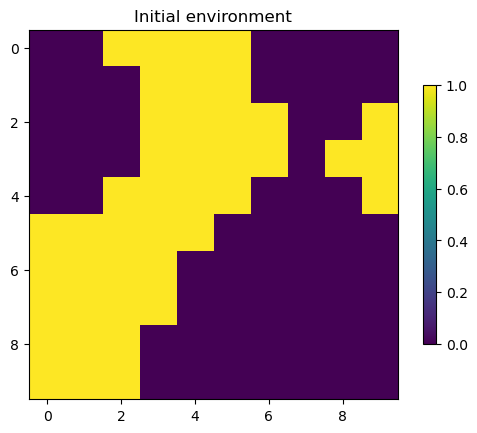

In [22]:
# Visualize Environment
fig = plt.figure()
plot = plt.imshow(lattice.env[..., 6])
plt.title("Initial environment")
fig.colorbar(plot, shrink=0.7)

In [23]:
# Run simulation
lattice.set_search_params(min_prod=1, neigh_type="von_neumann", distance=1, select_random_cell=False)
lattice.set_evolution_params(env_mutation_rate=0.001, skill_mutation_rate=0.001, skill_mutates_randomly=False)

lattice.run()

Text(0.5, 1.0, 'Population dynamics for a selected cell')

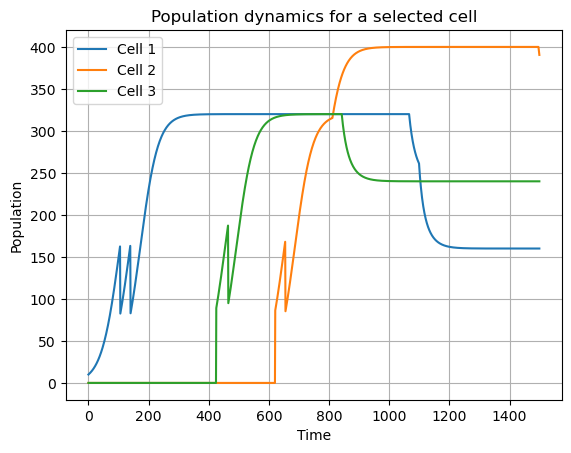

In [24]:
pop_t = lattice.population

plt.plot(pop_t[:1500, 0, 0], label="Cell 1")
plt.plot(pop_t[:1500, 2, 9], label="Cell 2")
plt.plot(pop_t[:1500, 3, 5], label="Cell 3")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Population")
plt.grid()
plt.title("Population dynamics for a selected cell")

Text(0.5, 1.0, 'Total population')

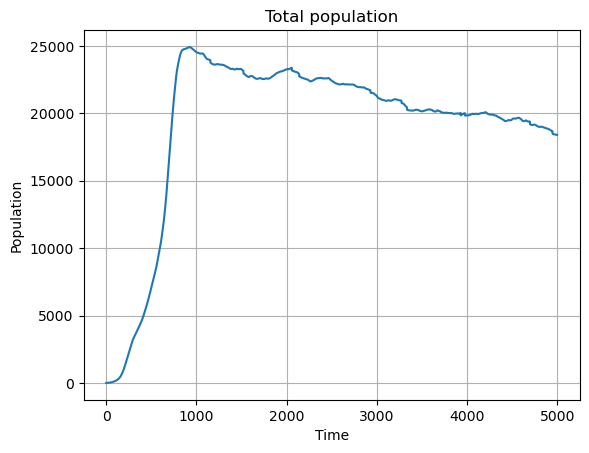

In [25]:
# Get entire population
pop_total = np.sum(pop_t, axis=(1, 2))

plt.plot(pop_total)
plt.grid()
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Total population")

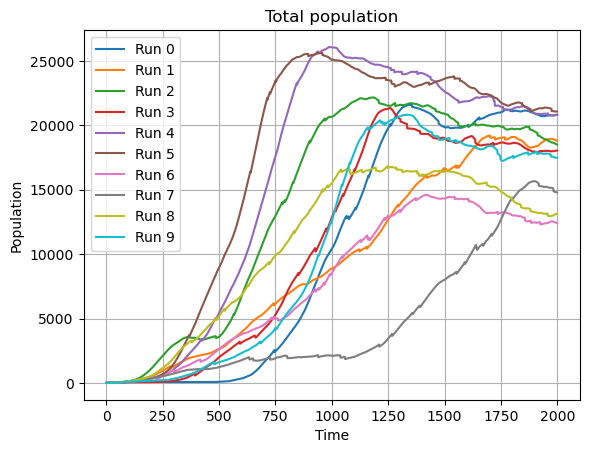

In [9]:
# Run for multiple simulations
fig = plt.figure()
plt.grid()
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Total population")

for ii, ll in enumerate(lattice_diff_seeds):
    ll.run(mutate_env=0.001, mutate_skill=0.0001)
    pop_ll = np.sum(ll.population[:2000], axis=(1, 2))
    plt.plot(pop_ll, label=f"Run {ii}")

plt.legend()

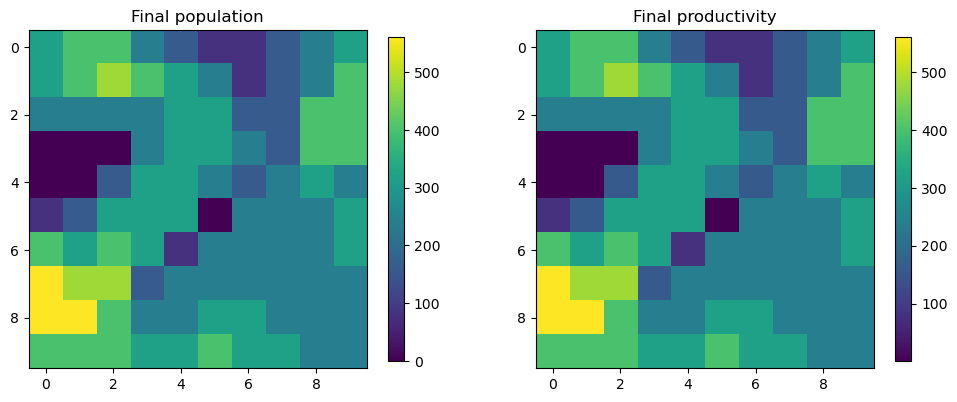

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plot1 = ax1.imshow(lattice.population[-1, :, :])
ax1.set_title("Final population")
fig.colorbar(plot1, ax=ax1, shrink=0.7)

plot2 = ax2.imshow(lattice.prod)
ax2.set_title("Final productivity")
fig.colorbar(plot2, ax=ax2, shrink=0.7)

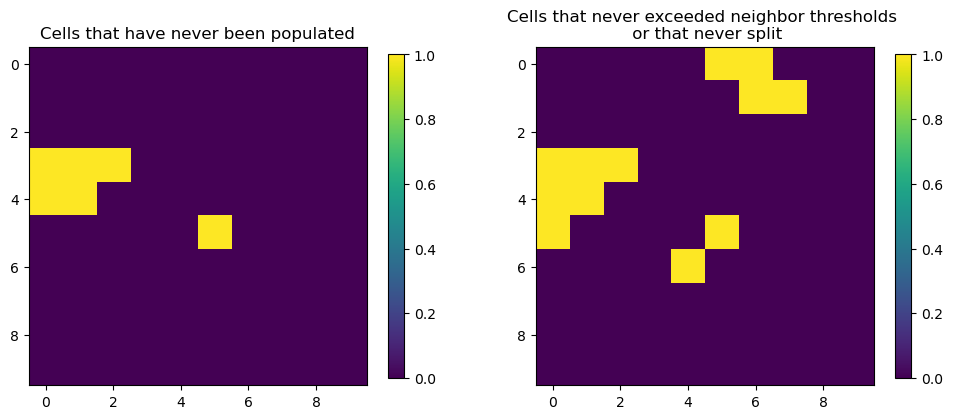

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plot1 = ax1.imshow(lattice.is_empty)
ax1.set_title("Cells that have never been populated")
fig.colorbar(plot1, ax=ax1, shrink=0.7)

plot2 = ax2.imshow(lattice.has_empty_neighbors)
ax2.set_title("Cells that never exceeded neighbor thresholds \n or that never split")
fig.colorbar(plot2, ax=ax2, shrink=0.7)

In [ ]:
# A cell that never exceeds neighbor thresholds means that this cell either hasn't split often enough (because there productivity is so low), or
# perhaps the name has no empty neighbors is misleading